In [1]:
import math
import torch
import gpytorch
import pyro
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
train_x = torch.linspace(0, 1, 100)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi)))
#train_y[train_y == -1] = 0

In [3]:
from gpytorch.variational import VariationalDistribution, NewVariationalStrategy
from gpytorch.models import PyroVariationalGP

class PyroGPClassificationModel(PyroVariationalGP):
    def __init__(self, likelihood, inducing_points):
        variational_distribution = VariationalDistribution(inducing_points.size(0))
        variational_strategy = NewVariationalStrategy(self, inducing_points, variational_distribution)
        super(PyroGPClassificationModel, self).__init__(variational_strategy, likelihood, name_prefix="basic_gp_test")
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x).add_jitter(1e-2)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
model = PyroGPClassificationModel(likelihood, train_x)

In [4]:
from pyro import optim
from pyro import infer

optimizer = optim.Adam({"lr": 0.1})

elbo = infer.Trace_ELBO(num_particles=200, vectorize_particles=True)
svi = infer.SVI(model.model, model.guide, optimizer, elbo)

In [2]:
num_epochs = 1

for i in range(num_epochs):
    # Within each iteration, we will go over each minibatch of data
    for minibatch_i, (x_batch, y_batch) in enumerate(train_loader):
        loss = svi.step(x_batch, y_batch)
        print('loss', loss)

NameError: name 'train_loader' is not defined

In [8]:
model.eval()
test_x = torch.linspace(0, 1, 30)
pred_dist = model(test_x)

In [10]:
pred_y = likelihood(pred_dist)

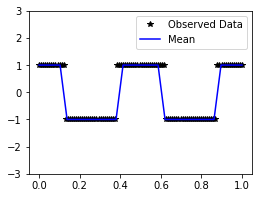

In [11]:
# Initialize fig and axes for plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
# Get the predicted labels (probabilites of belonging to the positive class)
# Transform these probabilities to be 0/1 labels
pred_labels = pred_y.mean.ge(0.5).float().mul(2).sub(1)
ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])